# Sentiment Analysis 

## 1. Import Libraries

In [2]:
!pip install emoji

     |████████████████████████████████| 131 kB 8.1 MB/s eta 0:00:01


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import lbsa
from sklearn.base import BaseEstimator, TransformerMixin
import re, string, os, emoji
import nltk
import collections
from pprint import pprint
from time import time

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, plot_confusion_matrix

## 2. Load Data

In [6]:
pd.options.display.max_colwidth=200

# extract 2000 data from train dataset
data = pd.read_csv('corona_NLP_train_2000.csv')

In [7]:
# display
data.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive


In [8]:
# information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       2000 non-null   int64 
 1   ScreenName     2000 non-null   int64 
 2   Location       1591 non-null   object
 3   TweetAt        2000 non-null   object
 4   OriginalTweet  2000 non-null   object
 5   Sentiment      2000 non-null   object
dtypes: int64(2), object(4)
memory usage: 93.9+ KB


Wrong data type for TweetAt --> Datetime + Missing location data.

In [6]:
# data['TweetAt'] = pd.to_datetime(data['TweetAt'])

In [9]:
# select variables
df = data[['OriginalTweet', 'Sentiment']].copy()

In [10]:
# extract the text
tweet = list(data['OriginalTweet'])

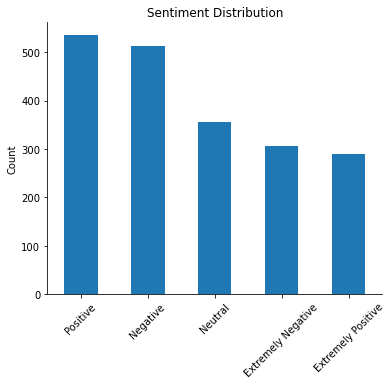

In [29]:
# visualize sentiment 
ax = df['Sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution', figsize=(6,5), rot=45)
ax.set_ylabel('Count')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

### (a) Extract lexicon-based features

In [12]:
afinn_lexicon = lbsa.get_lexicon('opinion', language='english', source='afinn')
nrc_lexicon = lbsa.get_lexicon('opinion', language='english', source='nrc')
nrc_sa_lexicon = lbsa.get_lexicon('sa', language='english', source='nrc')
mpqa_lexicon = lbsa.get_lexicon('opinion', language='english', source='mpqa')

In [17]:
nrc_sa_lexicon

In [13]:
# feature extraction
extractor = lbsa.FeatureExtractor(afinn_lexicon, nrc_lexicon, nrc_sa_lexicon, mpqa_lexicon)
f_data = pd.DataFrame(extractor.process(tweet), columns=extractor.feature_names)
f_data.head()

,afinn_positive,afinn_negative,nrc_positive,nrc_negative,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_sadness,nrc_surprise,nrc_trust,mpqa_positive,mpqa_negative,mpqa_strong_subjectivty
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,9.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,5.0,2.0,0.0,0.0
2,2.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
3,4.0,4.0,5.0,2.0,1.0,0.0,0.0,2.0,3.0,1.0,0.0,4.0,4.0,2.0,4.0
4,1.0,6.0,2.0,3.0,2.0,1.0,0.0,3.0,1.0,2.0,0.0,2.0,2.0,6.0,4.0


In [14]:
# concat the dataset with lexicon-based features
df_lex = pd.concat([df, f_data], axis=1)

Describe whether there is any lexicon-based feature that has some level of
relation to the sentiment.

In [20]:
# recategorize
df_lex.loc[(df_lex['Sentiment']=='Positive') | (df_lex['Sentiment']=='Extremely Positive'),'Sentiment'] = 'Positive'
df_lex.loc[(df_lex['Sentiment']=='Negative') | (df_lex['Sentiment']=='Extremely Negative'),'Sentiment'] = 'Negative'

In [21]:
def show_relation(df, col):
    print('-------------------------------\nDescription Statistics for {}\n-------------------------------'.format(col))
    print(df.groupby('Sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='Sentiment', height=5, hue='Sentiment')
    g = g.map(sns.histplot, col, kde=True, stat='density', bins=bins)
    plt.show() 

-------------------------------
Description Statistics for afinn_positive
-------------------------------
           count      mean       std  min  25%  50%  75%   max
Sentiment                                                     
Negative   819.0  0.921856  1.369864  0.0  0.0  0.0  2.0   7.0
Neutral    356.0  0.238764  0.886050  0.0  0.0  0.0  0.0  11.0
Positive   825.0  2.894545  2.340501  0.0  1.0  2.0  4.0  16.0


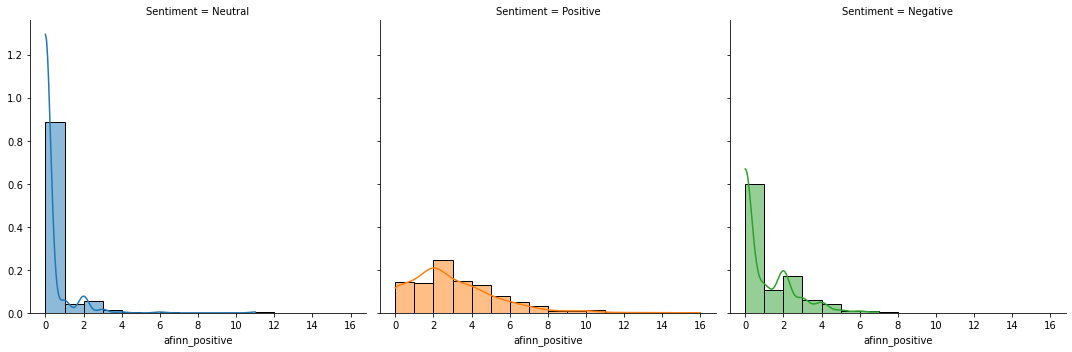

-------------------------------
Description Statistics for afinn_negative
-------------------------------
           count      mean       std  min  25%  50%  75%   max
Sentiment                                                     
Negative   819.0  4.313797  3.275148  0.0  2.0  4.0  6.0  31.0
Neutral    356.0  0.373596  1.003251  0.0  0.0  0.0  0.0   7.0
Positive   825.0  1.172121  1.634563  0.0  0.0  0.0  2.0  11.0


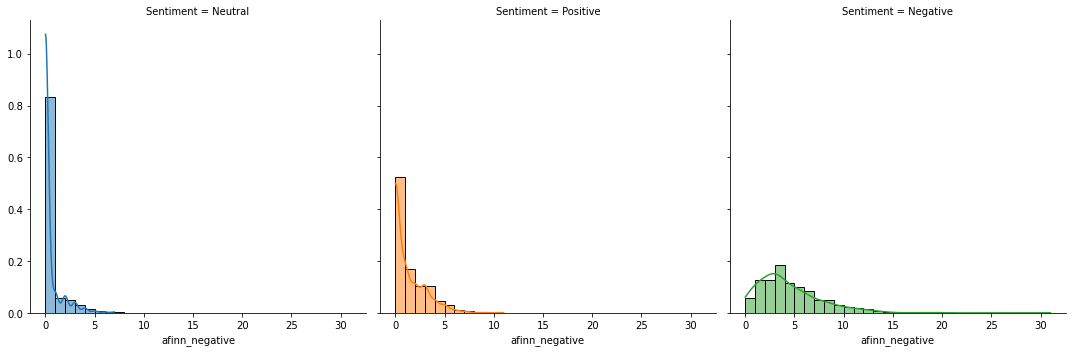

-------------------------------
Description Statistics for nrc_positive
-------------------------------
           count      mean       std  min  25%  50%  75%   max
Sentiment                                                     
Negative   819.0  1.936508  1.441058  0.0  1.0  2.0  3.0   8.0
Neutral    356.0  1.286517  1.182948  0.0  0.0  1.0  2.0   7.0
Positive   825.0  2.418182  1.640924  0.0  1.0  2.0  3.0  10.0


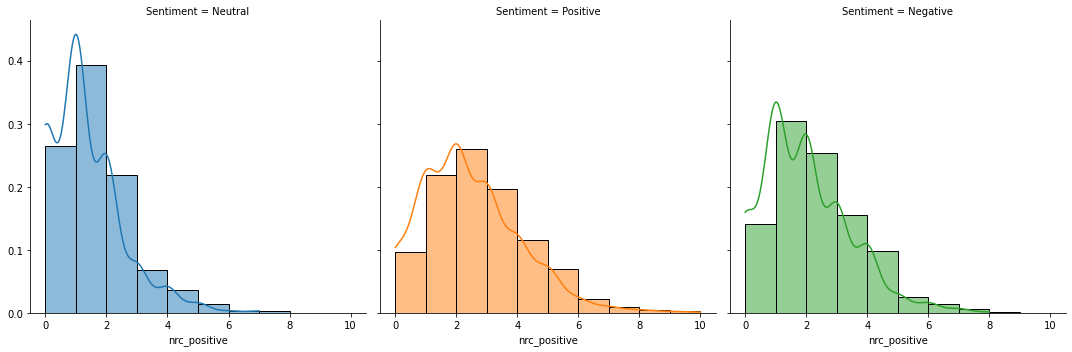

-------------------------------
Description Statistics for nrc_negative
-------------------------------
           count      mean       std  min  25%  50%  75%  max
Sentiment                                                    
Negative   819.0  1.894994  1.403353  0.0  1.0  2.0  3.0  8.0
Neutral    356.0  0.505618  0.799628  0.0  0.0  0.0  1.0  4.0
Positive   825.0  0.877576  1.044307  0.0  0.0  1.0  1.0  6.0


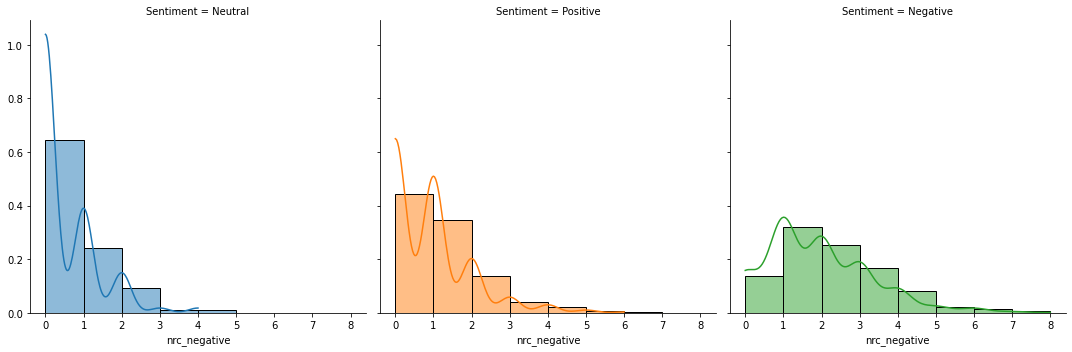

-------------------------------
Description Statistics for nrc_anger
-------------------------------
           count      mean       std  min  25%  50%  75%  max
Sentiment                                                    
Negative   819.0  0.666667  0.864966  0.0  0.0  0.0  1.0  5.0
Neutral    356.0  0.120787  0.389316  0.0  0.0  0.0  0.0  4.0
Positive   825.0  0.235152  0.505288  0.0  0.0  0.0  0.0  3.0


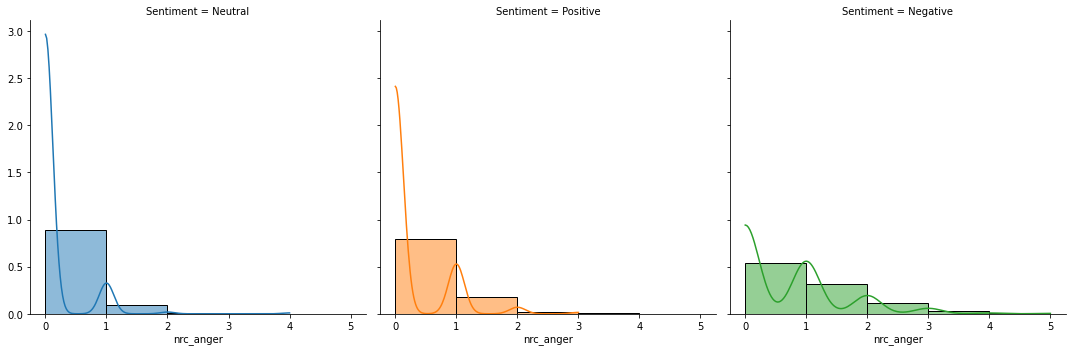

-------------------------------
Description Statistics for nrc_anticipation
-------------------------------
           count      mean       std  min  25%  50%  75%  max
Sentiment                                                    
Negative   819.0  0.969475  1.049063  0.0  0.0  1.0  2.0  6.0
Neutral    356.0  0.823034  0.862115  0.0  0.0  1.0  1.0  5.0
Positive   825.0  1.187879  1.120137  0.0  0.0  1.0  2.0  6.0


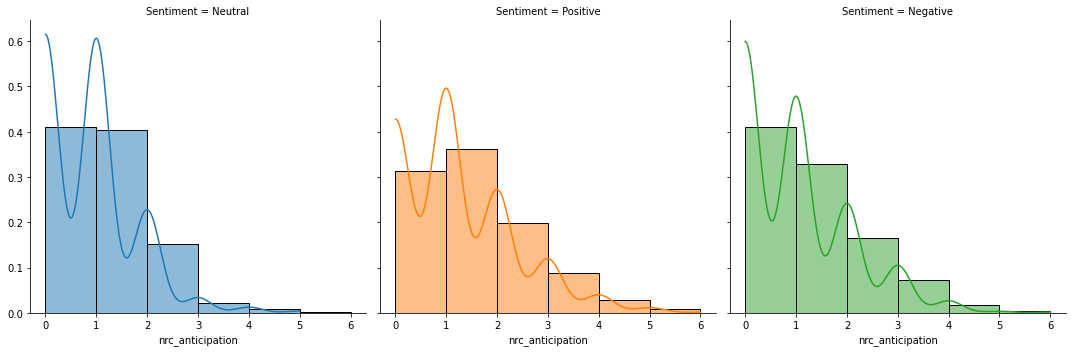

-------------------------------
Description Statistics for nrc_disgust
-------------------------------
           count      mean       std  min  25%  50%  75%  max
Sentiment                                                    
Negative   819.0  0.448107  0.710164  0.0  0.0  0.0  1.0  4.0
Neutral    356.0  0.112360  0.341932  0.0  0.0  0.0  0.0  2.0
Positive   825.0  0.146667  0.389880  0.0  0.0  0.0  0.0  2.0


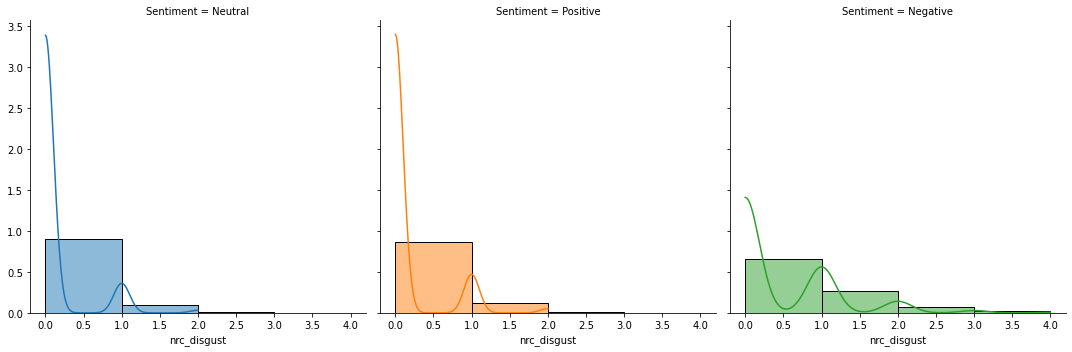

-------------------------------
Description Statistics for nrc_fear
-------------------------------
           count      mean       std  min  25%  50%  75%  max
Sentiment                                                    
Negative   819.0  1.161172  1.135515  0.0  0.0  1.0  2.0  6.0
Neutral    356.0  0.339888  0.627702  0.0  0.0  0.0  1.0  3.0
Positive   825.0  0.572121  0.831684  0.0  0.0  0.0  1.0  5.0


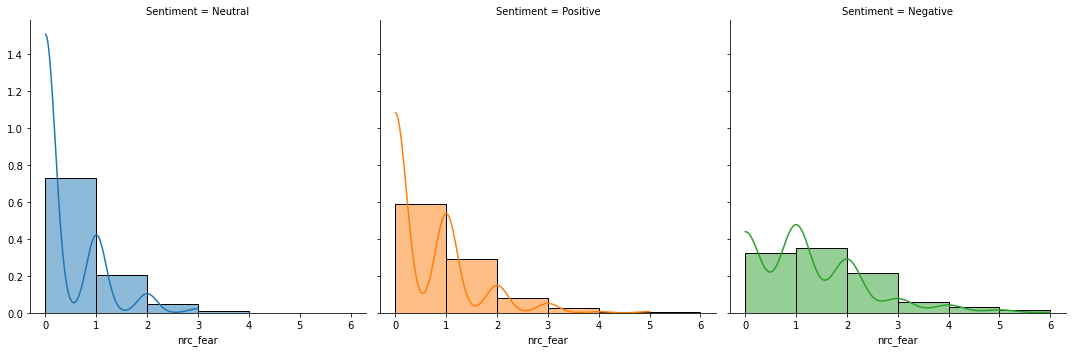

-------------------------------
Description Statistics for nrc_joy
-------------------------------
           count      mean       std  min  25%  50%  75%  max
Sentiment                                                    
Negative   819.0  0.747253  0.855502  0.0  0.0  1.0  1.0  6.0
Neutral    356.0  0.435393  0.695081  0.0  0.0  0.0  1.0  4.0
Positive   825.0  0.956364  0.949213  0.0  0.0  1.0  1.0  5.0


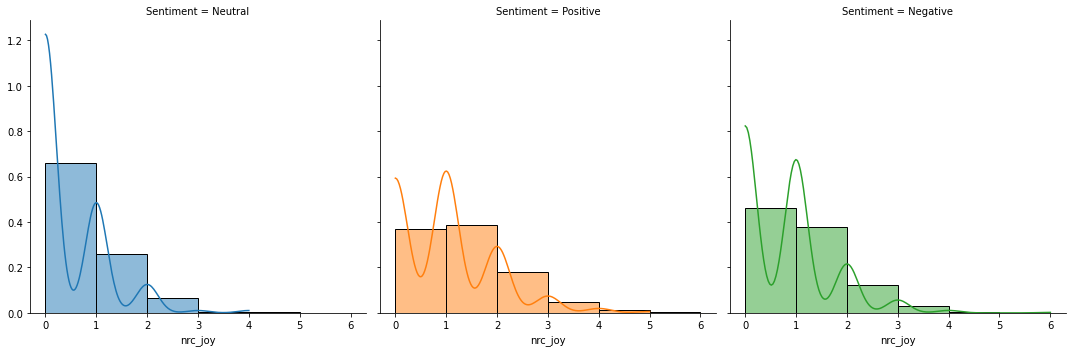

-------------------------------
Description Statistics for nrc_sadness
-------------------------------
           count      mean       std  min  25%  50%  75%  max
Sentiment                                                    
Negative   819.0  0.697192  0.889289  0.0  0.0  0.0  1.0  6.0
Neutral    356.0  0.210674  0.506853  0.0  0.0  0.0  0.0  4.0
Positive   825.0  0.366061  0.643724  0.0  0.0  0.0  1.0  4.0


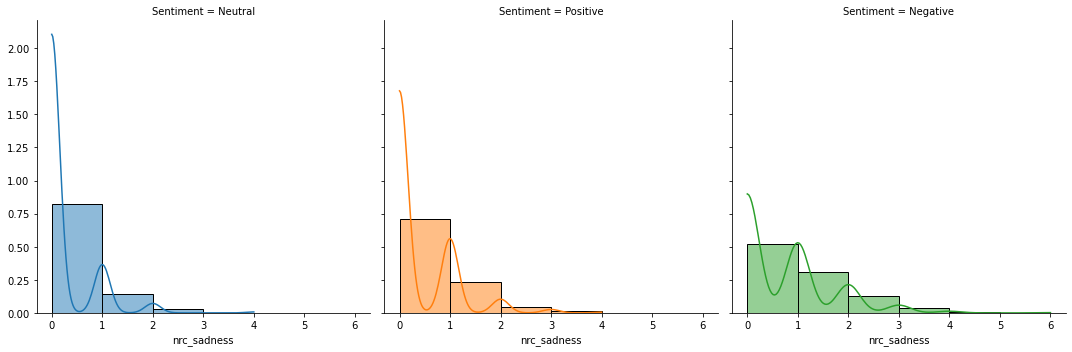

-------------------------------
Description Statistics for nrc_surprise
-------------------------------
           count      mean       std  min  25%  50%  75%  max
Sentiment                                                    
Negative   819.0  0.352869  0.632282  0.0  0.0  0.0  1.0  4.0
Neutral    356.0  0.283708  0.504474  0.0  0.0  0.0  1.0  2.0
Positive   825.0  0.435152  0.667175  0.0  0.0  0.0  1.0  4.0


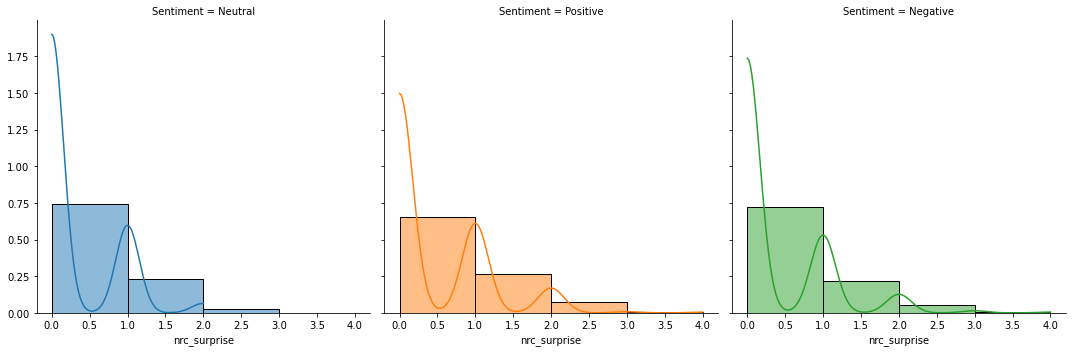

-------------------------------
Description Statistics for nrc_trust
-------------------------------
           count      mean       std  min  25%  50%  75%  max
Sentiment                                                    
Negative   819.0  1.170940  1.156500  0.0  0.0  1.0  2.0  8.0
Neutral    356.0  0.716292  0.961726  0.0  0.0  0.0  1.0  4.0
Positive   825.0  1.335758  1.168973  0.0  0.0  1.0  2.0  8.0


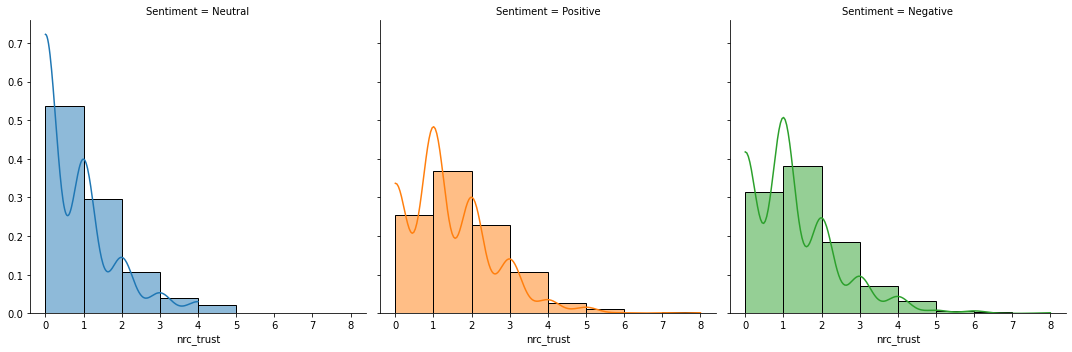

-------------------------------
Description Statistics for mpqa_positive
-------------------------------
           count      mean       std  min  25%  50%  75%   max
Sentiment                                                     
Negative   819.0  1.350427  1.306570  0.0  0.0  1.0  2.0   8.0
Neutral    356.0  0.581461  0.956280  0.0  0.0  0.0  1.0   6.0
Positive   825.0  2.229091  1.507144  0.0  1.0  2.0  3.0  10.0


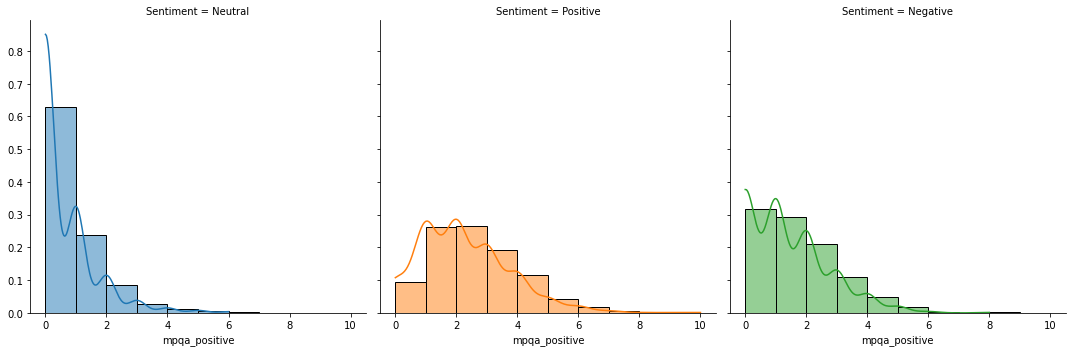

-------------------------------
Description Statistics for mpqa_negative
-------------------------------
           count      mean       std  min  25%  50%  75%  max
Sentiment                                                    
Negative   819.0  2.094017  1.468396  0.0  1.0  2.0  3.0  9.0
Neutral    356.0  0.522472  0.781512  0.0  0.0  0.0  1.0  4.0
Positive   825.0  0.950303  1.057200  0.0  0.0  1.0  2.0  7.0


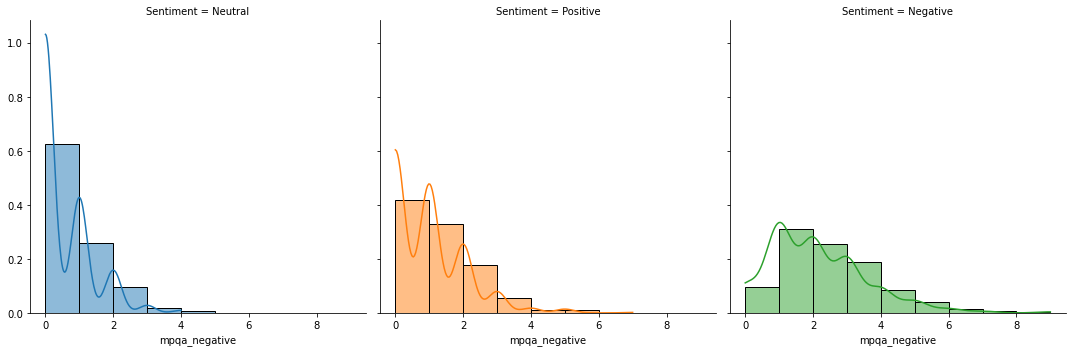

-------------------------------
Description Statistics for mpqa_strong_subjectivty
-------------------------------
           count      mean       std  min  25%  50%  75%   max
Sentiment                                                     
Negative   819.0  2.133089  1.640894  0.0  1.0  2.0  3.0  10.0
Neutral    356.0  0.609551  0.944558  0.0  0.0  0.0  1.0   5.0
Positive   825.0  1.808485  1.479529  0.0  1.0  1.0  3.0   9.0


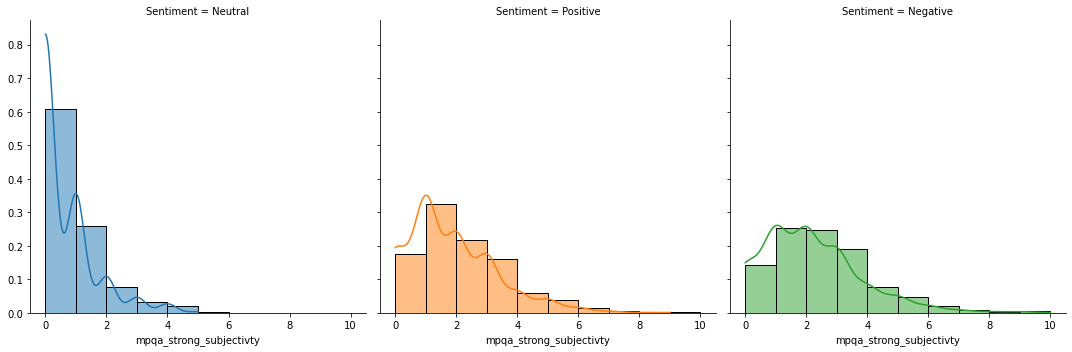

In [22]:
for f in extractor.feature_names:
    show_relation(df_lex, f)

**Observations:**

- There are relationship between sentiment outcome and lexicon-based features. The correlation is substantial with features such as afinn_positive, afinn_negative, nrc_negative, mpqa_positive, mpqa_negative since the distribution among sentiment classes ‘positive’, ‘negative’ and ‘neutral’ are not the same for these lexicon features.

### (b) Clean the text

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/truongt7/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
class CleanText(BaseEstimator, TransformerMixin):
    
    def remove_mentions(self, in_text):
        return re.sub(r'@\w+', '', in_text)
    
    def remove_urls(self, in_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', in_text)
    
    def emoji_oneword(self, in_text):
        # by compressing the underscore, the emoji is kept as one word
        return in_text.replace('_','')
    
    def remove_punctuation(self, in_text):
        # make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # every punctuation symbol will be replaced by a space
        return in_text.translate(trantab)

    def remove_digits(self, in_text):
        return re.sub('\d+', '', in_text)
    
    def to_lower(self, in_text):
        return in_text.lower()
    
    def remove_stopwords(self, in_text):
        stopwords_list = stopwords.words('english')
        # some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = in_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return ' '.join(clean_words) 
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords)
        return clean_X

In [30]:
c_func = CleanText()
tweet_clean = c_func.fit_transform(df_lex.OriginalTweet)

# verify the text after cleaning
tweet_clean.head(2)

0                                                                                                                                                                                                           
1    advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds not o...
Name: OriginalTweet, dtype: object

There are some rows having no words left after cleaning. For the CountVectorizer and TfIdfVectorizer this does not pose a problem. Yet, for the Word2Vec algorithm this causes an error. Replace with ['no_text']

In [31]:
empty = tweet_clean == ''
print('{} rows have no words left after cleaning.'.format(empty[empty == True].sum()))

4 rows have no words left after cleaning.


In [32]:
# add no_text to rows with no words left after cleaning
tweet_clean.loc[empty] = '[no_text]'

### (c) Create Bags of Words

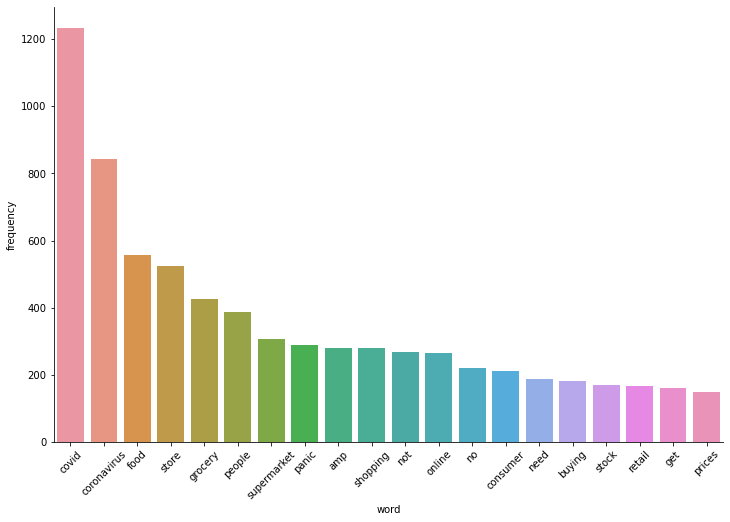

In [33]:
cv = CountVectorizer()
bow = cv.fit_transform(tweet_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x="word", y="freq", data=word_counter_df, ax=ax)
ax.set_ylabel('frequency')
ax.set_xticklabels(word_counter_df.loc[:20, 'word'], rotation = 45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

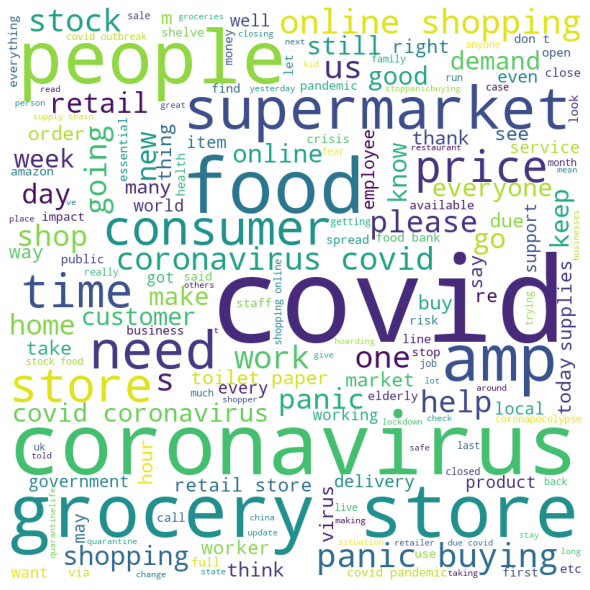

In [34]:
comment_words = ''
stopwords = set(STOPWORDS)

for v in tweet_clean: 
    v = str(v)
    tokens = v.split()
    comment_words += ' '.join(tokens) + ' ' 

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white',
                      stopwords = stopwords, 
                      min_font_size = 10).generate(comment_words) 

# plot WordCloud image                        
plt.figure(figsize = (8, 8), facecolor='white') 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0);

In [35]:
df_lex['clean_text'] = tweet_clean

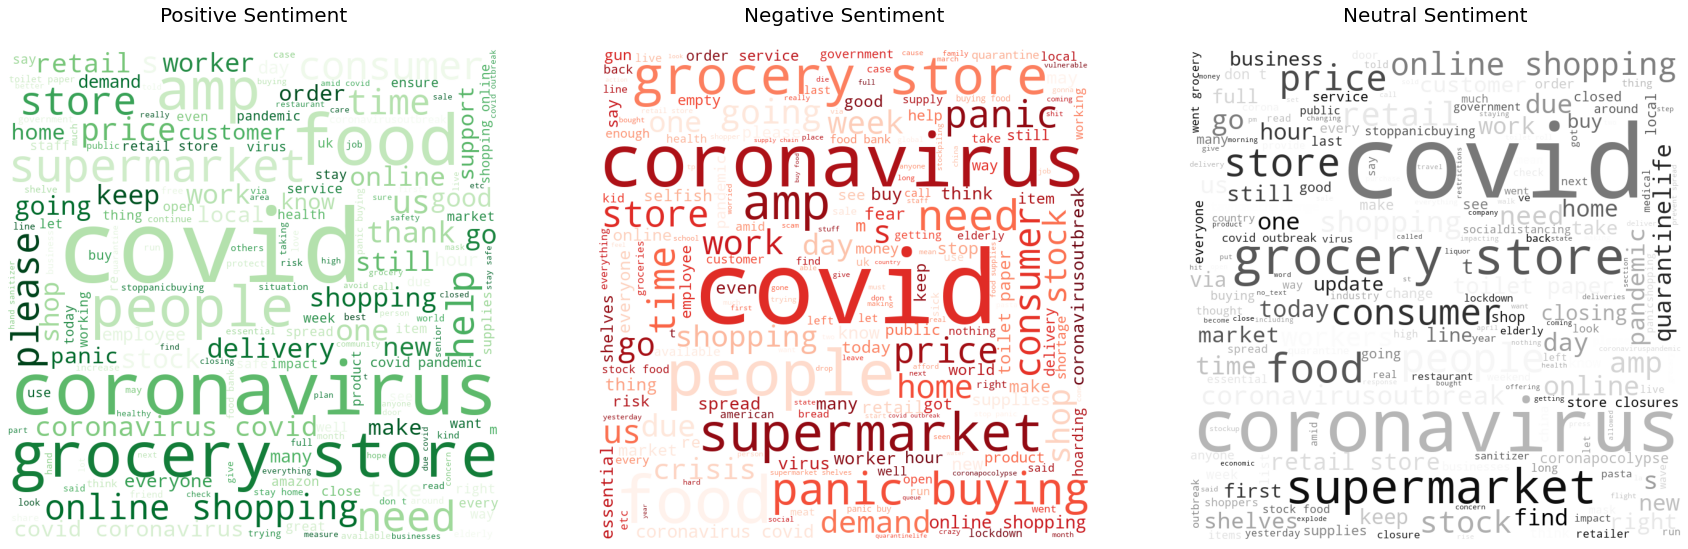

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

df_pos = df_lex[(df_lex['Sentiment']=='Positive') | (df_lex['Sentiment']=='Extremely Positive')]
df_neg = df_lex[(df_lex['Sentiment']=='Negative') | (df_lex['Sentiment']=='Extremely Negative')]
df_neu = df_lex[df_lex['Sentiment']=='Neutral']

comment_words = '' 
stopwords = set(STOPWORDS) 

for val in df_pos.clean_text:  
    val = str(val) 
    tokens = val.split() 
    comment_words += ' '.join(tokens)+' '
    
wordcloud1 = WordCloud(width = 800, height = 800, 
                        background_color ='white',
                        colormap='Greens',
                        stopwords = stopwords, 
                        min_font_size = 10).generate(comment_words) 

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment\n', fontsize=20);

comment_words = ''

for val in df_neg.clean_text: 
    val = str(val) 
    tokens = val.split() 
    comment_words += ' '.join(tokens)+' '

wordcloud2 = WordCloud(width = 800, height = 800, 
                        background_color ='white',
                        colormap='Reds',
                        stopwords = stopwords, 
                        min_font_size = 10).generate(comment_words)  

ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment\n', fontsize=20);

comment_words = ''
for val in df_neu.clean_text: 
    val = str(val) 
    tokens = val.split() 
    comment_words += ' '.join(tokens)+' '

wordcloud3 = WordCloud(width = 800, height = 800, 
                        background_color ='white',
                        colormap='Greys',
                        stopwords = stopwords, 
                        min_font_size = 10).generate(comment_words) 

ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral Sentiment\n', fontsize=20);

Comments:
- `covid` and `coronavirus` are the most frequent word. The result is reasonable since this dataset contains tweets about Coronavirus.

### (d) Discuss at least two other types of representations than the BOW

*Advanced BOW*

In [58]:
# extract a few tweets 
tf_text = tweet_clean[:2]

In [68]:
tf = TfidfVectorizer()
txt_fitted = tf.fit(tf_text)
txt_transformed = txt_fitted.transform(tweet_clean)
idf = tf.idf_
pd.DataFrame.from_dict(dict(zip(txt_fitted.get_feature_names(), idf)), orient='index')

,0
accounts,1.405465
adequate,1.405465
advice,1.405465
chemist,1.405465
contact,1.405465
create,1.405465
employer,1.405465
exchange,1.405465
family,1.405465
gp,1.405465


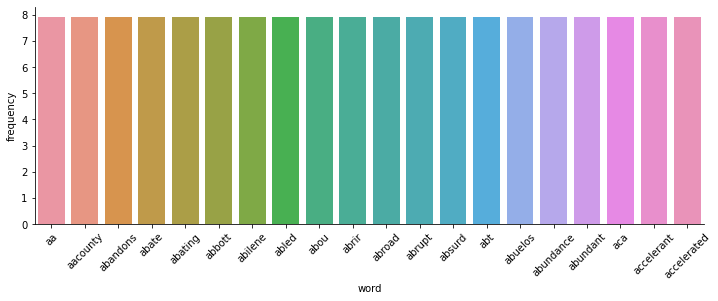

In [70]:
# fit the whole dataset
tf = TfidfVectorizer()
txt_fitted = tf.fit(tweet_clean)
txt_transformed = txt_fitted.transform(tweet_clean)
idf = tf.idf_
word_freq = dict(zip(txt_fitted.get_feature_names(), idf))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x="word", y="freq", data=word_counter_df, ax=ax)
ax.set_ylabel('frequency')
ax.set_xticklabels(word_counter_df.loc[:20, 'word'], rotation = 45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

Ref: https://towardsdatascience.com/introduction-to-text-representations-for-language-processing-part-1-dc6e8068b8a4

*Word2Vec*

In [73]:
!nltk.download('punkt')

# tokenize
data = []
for i in tweet_clean:
    temp = []
    for j in word_tokenize(i):
        temp.append(j.lower())  
    data.append(temp)

/bin/bash: -c: line 0: syntax error near unexpected token `'punkt''
/bin/bash: -c: line 0: `nltk.download('punkt')'


In [77]:
# import warnings
# warnings.filterwarnings(action = 'ignore')

# create CBOW model
model1 = gensim.models.Word2Vec(data, min_count=1, size=100, window=5)
s1 = model1.wv.similarity('covid', 'coronavirus')
s2 = model1.wv.similarity('bake', 'food') 
print("Cosine similarity between 'covid' and 'coronavirus' is " + str(s1))
print("Cosine similarity between 'bake' and 'food' is " + str(s2))

Cosine similarity between 'covid' and 'coronavirus' is 0.9999333
Cosine similarity between 'bake' and 'food' is 0.5384007


In [75]:
# top 10 similar words to grocery based on Cosin Similarity - model 1
model1.wv.most_similar('grocery', topn=10)

[('covid', 0.9998494386672974),
 ('amp', 0.9998419880867004),
 ('store', 0.9998393058776855),
 ('supermarket', 0.999835193157196),
 ('food', 0.9998303651809692),
 ('retail', 0.9998302459716797),
 ('prices', 0.9998279213905334),
 ('people', 0.9998260140419006),
 ('consumer', 0.9998258352279663),
 ('go', 0.9998238682746887)]

In [78]:
# create Skip Gram model
model2 = gensim.models.Word2Vec(data, min_count = 1, size=100, window=5, sg=1)
s1 = model2.wv.similarity('covid', 'coronavirus')
s2 = model2.wv.similarity('bake', 'food')
print("Cosine similarity between 'covid' and 'coronavirus' is " + str(s1))
print("Cosine similarity between 'bake' and 'food' is " + str(s2))  

Cosine similarity between 'covid' and 'coronavirus' is 0.9990964
Cosine similarity between 'bake' and 'food' is 0.97758627


In [79]:
# top 10 similar words to grocery based on Cosin Similarity - model 2
model2.wv.most_similar('grocery', topn=10)

[('retail', 0.9966992139816284),
 ('went', 0.995732843875885),
 ('workers', 0.99563068151474),
 ('employees', 0.9956086874008179),
 ('store', 0.995407223701477),
 ('today', 0.9952310919761658),
 ('time', 0.9951484203338623),
 ('go', 0.995031476020813),
 ('stores', 0.9950146079063416),
 ('work', 0.9950020909309387)]

Ref: https://stackabuse.com/implementing-word2vec-with-gensim-library-in-python/

Ref: https://medium.com/analytics-vidhya/theory-behind-word-embeddings-in-word2vec-858b9350870b 

## 3. Model

Models:
- Multinomial Naive Bayes classifier
- Logistic Regression

To train the models, I use **CountVectorizer** to convert words to numbers by assigning them an id and counting word frequencies. 
Estimate the model with 5-fold crossvalidation to avoid overfitting.

Evaluation metrics:
- Precision
- Recall
- F1 score
- Confusion matrix

In [81]:
df_lex.loc[df_lex['Sentiment'] == 'Extremely Negative','Sentiment'] = 'Negative'
df_lex.loc[df_lex['Sentiment'] == 'Extremely Positive','Sentiment'] = 'Positive'

In [82]:
# df_lex['clean_text'] = tweet_clean
df_model = df_lex.copy()

In [83]:
y = df_lex['Sentiment']
X = df_model.drop(['OriginalTweet','Sentiment'], axis=1)

In [84]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [85]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

*Logistic Regression*

In [86]:
mnb = MultinomialNB()
logreg = LogisticRegression(max_iter=10000, solver='saga')
countvect = CountVectorizer()

def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['afinn_positive', 'afinn_negative', 'nrc_positive', 'nrc_negative', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust',
                      'nrc_fear', 'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust', 'mpqa_positive', 'mpqa_negative', 'mpqa_strong_subjectivty']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols)),
                                 ('w2v', ColumnExtractor(cols=w2vcols))], n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols)),
                                 ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))], n_jobs=-1)

    pipeline = Pipeline([('features', features), ('clf', clf)])
    
    # join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print('Performing grid search...')
    print('Pipeline:', [name for name, _ in pipeline.steps])
    print('Parameters:')
    print(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print('Done in %0.3fs' % (time() - t0))
    print()

    print('Best CV score: %0.3f' % grid_search.best_score_)
    print('Best parameters set:')
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
        
    print('Test score with best_estimator_: %0.3f' % grid_search.best_estimator_.score(X_test, y_test))
    print('\n')
    print('Classification Report Test Data')
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [87]:
# parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

# parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [88]:
# Logistic Regression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
Pipeline: ['features', 'clf']
Parameters:
{'features__pipe__vect__max_df': (0.25, 0.5, 0.75), 'features__pipe__vect__ngram_range': ((1, 1), (1, 2)), 'features__pipe__vect__min_df': (1, 2), 'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  8.7min finished


Done in 522.741s

Best CV score: 0.824
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.808


Classification Report Test Data
              precision    recall  f1-score   support

    Negative       0.80      0.86      0.83       232
     Neutral       0.78      0.69      0.73       120
    Positive       0.83      0.82      0.83       248

    accuracy                           0.81       600
   macro avg       0.80      0.79      0.79       600
weighted avg       0.81      0.81      0.81       600



In [94]:
logreg_test_preds = X_test.loc[:, ['clean_text']]
logreg_test_preds['Sentiment'] = y_test
logreg_test_preds['Prediction'] = best_logreg_countvect.predict(X_test)
logreg_test_preds

,clean_text,Sentiment,Prediction
1860,rather give billions bailouts corporations compensate product consumers not buy use bail consumer encourage sales product buy consumers drive markets not,Positive,Positive
353,pls tell pharmacist drop prices sanitizers cruel africanhistoryclass covid taxidrivershow taxijam blackpot,Negative,Negative
1333,online shopping creaking time prioritise elderly customers covid stayhomechallenge,Neutral,Neutral
905,overheard grocery store i like frozen food better fresh anyways boyyyy ex girl coronavirus,Positive,Positive
1289,londoners anyone uk actually help food bank local area feed elderly vulnerable difficult time panic buying meant facing shortages please help,Negative,Negative
...,...,...,...
148,dear hoarder covid covid coronapocolypse coronavirus covid hoarders groceries panicshopping stoppanicbuying,Positive,Positive
1554,seriously stop sending emails telling seriously take covid not interested supermarket hotel marketing company bank interested hearing experts,Negative,Positive
1956,shout medical practitioners front line treating sick people sit home stock food,Negative,Negative
925,face severe blood shortage due unprecedented number blood drive cancellations coronavirus outbreak make appointment help patients counting lifesaving blood,Negative,Negative


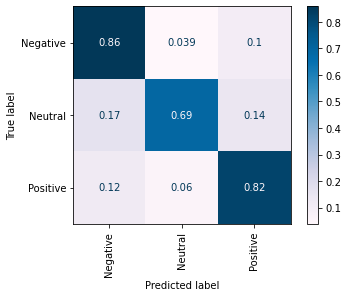

In [90]:
plot_confusion_matrix(best_logreg_countvect, X_test, y_test,
                      normalize='true', cmap='PuBu', xticks_rotation=90);

*Estimate Naive Bayes*

In [91]:
# parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.01, 0.1, 0.25, 0.5, 0.75)}

mnb = MultinomialNB()
countvect = CountVectorizer()
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
Pipeline: ['features', 'clf']
Parameters:
{'features__pipe__vect__max_df': (0.25, 0.5, 0.75), 'features__pipe__vect__ngram_range': ((1, 1), (1, 2)), 'features__pipe__vect__min_df': (1, 2), 'clf__alpha': (0.01, 0.1, 0.25, 0.5, 0.75)}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s


Done in 9.199s

Best CV score: 0.739
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.742


Classification Report Test Data
              precision    recall  f1-score   support

    Negative       0.73      0.87      0.79       232
     Neutral       0.78      0.38      0.51       120
    Positive       0.75      0.79      0.77       248

    accuracy                           0.74       600
   macro avg       0.75      0.68      0.69       600
weighted avg       0.75      0.74      0.73       600



[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.1s finished


In [92]:
mnb_test_preds = X_test.loc[:, ['clean_text']]
mnb_test_preds['Sentiment'] = y_test
mnb_test_preds['Prediction'] = best_mnb_countvect.predict(X_test)
mnb_test_preds

,clean_text,Sentiment,Prediction
1860,rather give billions bailouts corporations compensate product consumers not buy use bail consumer encourage sales product buy consumers drive markets not,Positive,Positive
353,pls tell pharmacist drop prices sanitizers cruel africanhistoryclass covid taxidrivershow taxijam blackpot,Negative,Negative
1333,online shopping creaking time prioritise elderly customers covid stayhomechallenge,Neutral,Positive
905,overheard grocery store i like frozen food better fresh anyways boyyyy ex girl coronavirus,Positive,Positive
1289,londoners anyone uk actually help food bank local area feed elderly vulnerable difficult time panic buying meant facing shortages please help,Negative,Negative
...,...,...,...
148,dear hoarder covid covid coronapocolypse coronavirus covid hoarders groceries panicshopping stoppanicbuying,Positive,Positive
1554,seriously stop sending emails telling seriously take covid not interested supermarket hotel marketing company bank interested hearing experts,Negative,Negative
1956,shout medical practitioners front line treating sick people sit home stock food,Negative,Negative
925,face severe blood shortage due unprecedented number blood drive cancellations coronavirus outbreak make appointment help patients counting lifesaving blood,Negative,Negative


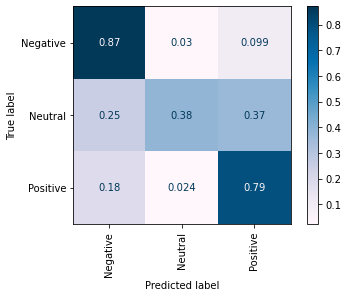

In [93]:
plot_confusion_matrix(best_mnb_countvect, X_test, y_test, 
                      normalize='true', cmap='PuBu', xticks_rotation=90);

## 4. Conclusion

The performance of Logistic Regression is much better than Naïve Bayes on test set as the latter performs bad especially in neutral sentiment. The recall for neutral class is low.
Improvement could be balancing the test set by oversampling to have better performance on neutral class.